In [132]:
import datetime
import random
import tracemalloc

import matplotlib.pyplot as plt
import numpy as np

INITIAL_LR = 1e-2

eps = 1e-7

cnt = [0]

def get_eps(dim):
    return np.ones(dim) * 1e-7


def quadratic_grad(x, w, y, n):
    # print("x", x)
    # print("y", y)
    # print("w", w)
    # print("grad", ((x.dot(w) - y).dot(x)) / n)
    cnt[0] += 1 + n * (2 * n + n + 5) + 1
    return ((x.dot(w) - y).dot(x)) / n


def quadratic_grad_l1(x, w, y, n):
    cnt[0] += 1 + n * (2 * n + n + 5) + 1 + 2 * n
    return ((x.dot(w) - y).dot(x)) / n + np.sum(w / np.abs(w))


def quadratic_grad_l2(x, w, y, n):
    cnt[0] += 1 + n * (2 * n + n + 5) + 1 + n
    return ((x.dot(w) - y).dot(x)) / n + np.sum(w)


def quadratic_grad_elastic(x, w, y, n, lambd1=0.5, lambd2=0.9):
    cnt[0] += 1 + n * (2 * n + n + 5) + 1 + 3 * n
    return ((x.dot(w) - y).dot(x)) / n + lambd2*np.sum(w) + lambd1*np.sum(w / np.abs(w))


class StochasticGradDescCommon:
    dimensions, current, v, result, points, batch_size, gamma, learning_rate, iteration = [None] * 9

    def init(self, X_data, y_data, batch_size, gamma, learning_rate):
        self.dimensions = X_data.shape[1]
        self.current = np.zeros(self.dimensions)
        self.result = self.current
        self.points = list(zip(X_data, y_data))
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.custom_init()

    def custom_init(self):
        pass

    def update(self, batch_x, batch_y):
        pass

    def get_batches(self, points):
        random.shuffle(points)
        batch_points = points[:self.batch_size]
        batch_x = np.array(list(map(lambda x: x[0], batch_points)))
        batch_y = np.array(list(map(lambda x: x[1], batch_points)))
        return batch_x, batch_y

    def get_error(self, batch_x, batch_y):
        # print("batch_x", batch_x)
        # print("current", self.current)
        # print("*", batch_x.dot(self.current))
        cnt[0] += 4 * len(batch_x)
        return np.sum(np.absolute(batch_x.dot(self.current) - batch_y)) / len(batch_x)

    def get_min(self, X_data, y_data, lr_schedule, learning_rate=INITIAL_LR, gamma=0.8,
                eps=1e-4, batch_size=1, max_iter=1000):
        self.init(X_data, y_data, batch_size, gamma, learning_rate)
        self.v = np.zeros(self.dimensions)
        self.result = np.vstack((self.result, self.current))
        for i in range(max_iter):
            self.iteration = i
            batch_x, batch_y = self.get_batches(self.points)
            error = self.get_error(batch_x, batch_y)
            if error < eps:
                return self.result
            self.update(batch_x, batch_y)
            self.result = np.vstack((self.result, self.current))
            learning_rate = lr_schedule(learning_rate, i)
        return self.result


class StochasticGradDesc(StochasticGradDescCommon):
    def update(self, batch_x, batch_y):
        cnt[0] += 2
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.current -= self.learning_rate * grad


class NesterovStochasticDesc(StochasticGradDescCommon):
    def custom_init(self):
        self.v = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 5
        self.v = self.v * self.gamma + (1 - self.gamma) \
                 * quadratic_grad(batch_x, 
                                  self.current - self.learning_rate * self.gamma * self.v, 
                                  batch_y,
                                  self.dimensions)
        self.current -= self.learning_rate * self.v

class MomentumStochasticDesc(StochasticGradDescCommon):
    def custom_init(self):
        self.v = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 5
        self.v = self.v * self.gamma + (1 - self.gamma) \
                 * quadratic_grad(batch_x,
                                  self.current,
                                  batch_y,
                                  self.dimensions)
        self.current -= self.learning_rate * self.v

class AdaGradStochasticDesc(StochasticGradDescCommon):
    g = None

    def custom_init(self):
        self.g = np.zeros((self.dimensions, self.dimensions))
        self.learning_rate *= 500

    def update(self, batch_x, batch_y):
        cnt[0] += len(batch_x) ** 2 + 2 * len(batch_x) + 4
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.g += np.outer(grad, grad)
        diag = np.sqrt(self.g.diagonal())
        self.current -= self.learning_rate * grad / (diag + get_eps(self.dimensions))


class RMSStochasticDesc(StochasticGradDescCommon):
    beta = 0.8
    s = None

    def custom_init(self):
        self.beta = 0.98
        self.learning_rate *= 500
        self.s = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += len(batch_x) ** 2 + len(batch_x) + 4
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.s = self.beta * self.s + (1 - self.beta) * grad * grad
        self.current -= self.learning_rate * grad / (np.linalg.norm(self.s) + eps)


class AdamStochasticDesc(StochasticGradDescCommon):
    beta_one, beta_two, s = [None] * 3

    def custom_init(self):
        self.beta_one = 0.9
        self.beta_two = 0.999
        self.learning_rate *= 500
        self.v = np.zeros(self.dimensions)
        self.s = np.zeros(self.dimensions)

    def get_grad(self, batch_x, batch_y):
        return quadratic_grad(batch_x, self.current, batch_y, self.dimensions)

    def update(self, batch_x, batch_y):
        p = len(batch_x)
        cnt[0] += p ** 2 + p + 10
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.v = self.beta_one * self.v + (1 - self.beta_one) * grad
        self.s = self.beta_two * self.s + (1 - self.beta_two) * grad * grad
        v_inv = self.v / (1 - self.beta_one ** (self.iteration + 1))
        s_inv = self.s / (1 - self.beta_two ** (self.iteration + 1))
        self.current -= self.learning_rate * v_inv / (np.linalg.norm(s_inv) + eps)


class AdamWithL1(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_l1(batch_x, self.current, batch_y, self.dimensions)


class AdamWithL2(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_l2(batch_x, self.current, batch_y, self.dimensions)


class AdamWithElasticNet(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_elastic(batch_x, self.current, batch_y, self.dimensions)


def const_lr(learning_rate, iter_num):
    return learning_rate


def step_lr(learning_rate,
            iter_num,
            initial_lr=INITIAL_LR,
            drop=1.2,
            frequency=10):
    return initial_lr * np.power(drop, np.floor((iter_num + 1) / frequency))


def exponential_lr(learning_rate,
                   iter_num,
                   initial_lr=INITIAL_LR,
                   k=1e-3):
    return initial_lr * np.exp(-k * iter_num)


def f(x):
    return 0.13 * x[0] + 4.41 * x[1]

data_size = 10
X = np.empty((data_size, 2))
Y = np.empty((data_size))
for i in range(data_size):
    x = np.random.uniform(-3, 3, 2)
    X[i] = x
    Y[i] = f(x) #+ np.random.rand()


def test(grad_desc, lr_scheduler, x, y):
    print()
    for batch_size in range(1, len(y) + 1):
        cnt[0] = 0
        tracemalloc.start()
        start = datetime.datetime.utcnow()
        result = grad_desc(x, y, lr_scheduler, batch_size=batch_size)
        comp_time = (datetime.datetime.utcnow() - start).total_seconds()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        values = result[-1]
        print(values)
        print(f'iterations: {len(result)}, batch_size: {batch_size}, computing_time: {comp_time}s, arithmetic operations: {cnt[0]}, peak was {peak / 10**6}MB')


def polynomial_regression(real_c, points_amount=20):
    x_points = []
    y_points = []
    xses = []
    dim = real_c.shape[0]
    for i in range(points_amount):
        x_value = float((np.random.rand(1) - 0.5) * 4)
        x_points_value = np.array([np.power(x_value, i) for i in range(dim)])
        y_value = real_c.dot(x_points_value)
        x_points.append(x_points_value)
        y_points.append(y_value)
        xses.append(x_value)
    x_points = np.array(x_points)
    y_points = np.array(y_points)
    y_points += np.random.normal(0, 0.5, points_amount)
    result = AdamWithElasticNet().get_min(x_points, y_points, exponential_lr, batch_size=points_amount // 10)
    print(real_c, result[-1], len(result))
    return result[-1], (xses, y_points)


[0.15555487 4.39711227]
iterations: 859, batch_size: 1, computing_time: 0.068175s, arithmetic operations: 25714, peak was 0.182674MB
[0.13077686 4.40965503]
iterations: 791, batch_size: 2, computing_time: 0.050614s, arithmetic operations: 26834, peak was 0.028349MB
[0.130475   4.40974739]
iterations: 498, batch_size: 3, computing_time: 0.032357s, arithmetic operations: 18860, peak was 0.018304MB
[0.13017187 4.4099257 ]
iterations: 427, batch_size: 4, computing_time: 0.037065s, arithmetic operations: 17866, peak was 0.015984MB
[0.13017823 4.4099102 ]
iterations: 371, batch_size: 5, computing_time: 0.024252s, arithmetic operations: 16994, peak was 0.014272MB
[0.13018588 4.40991747]
iterations: 309, batch_size: 6, computing_time: 0.024353s, arithmetic operations: 15374, peak was 0.160271MB
[0.13013647 4.40994021]
iterations: 258, batch_size: 7, computing_time: 0.019303s, arithmetic operations: 13852, peak was 0.158651MB
[0.13011517 4.40994946]
iterations: 239, batch_size: 8, computing_ti

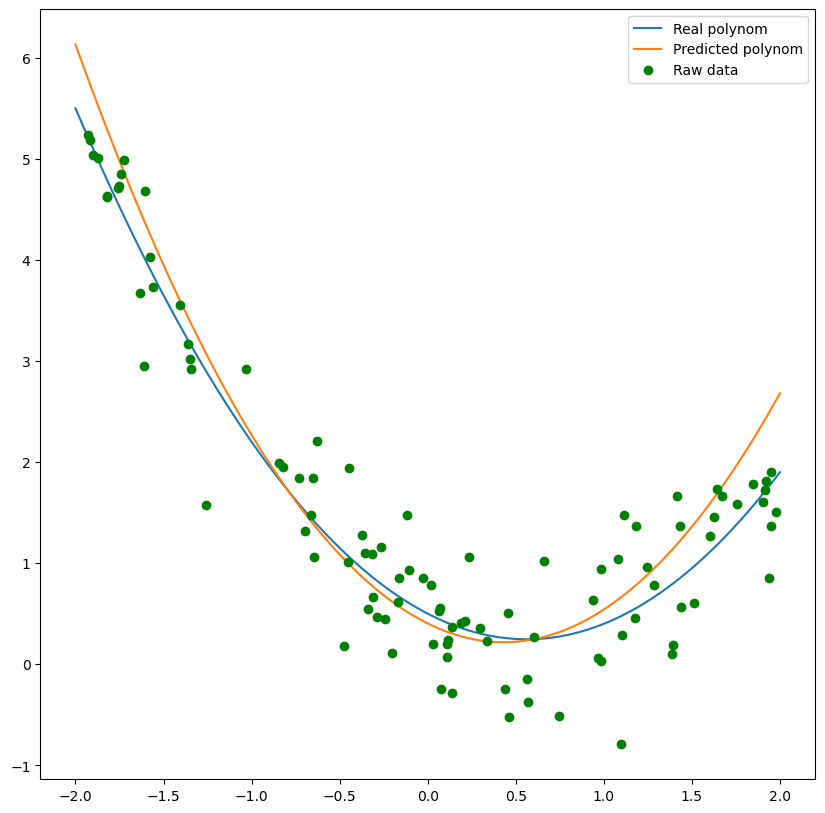

In [133]:
# constant learning rate
test(StochasticGradDesc().get_min, exponential_lr, X, Y)

# exponential learning rate
test(StochasticGradDesc().get_min, exponential_lr, X, Y)

# Nesterov optimisation
test(NesterovStochasticDesc().get_min, exponential_lr, X, Y)

# AdaGrad optimisation
test(AdaGradStochasticDesc().get_min, exponential_lr, X, Y)

# RMSProp optimisation
test(RMSStochasticDesc().get_min, exponential_lr, X, Y)

# Adam optimisation
test(AdamStochasticDesc().get_min, exponential_lr, X, Y)

# Polynomial regression
print()
coeffs = np.array([0.5, -0.9, 0.8])
data = polynomial_regression(coeffs, 100)
predicted_coeffs = data[0]
points = data[1]

coeffs = np.flip(coeffs)
predicted_coeffs = np.flip(predicted_coeffs)
x = np.linspace(-2, 2, 100)
y1 = [np.polyval(coeffs, i) for i in x]
y2 = [np.polyval(predicted_coeffs, i) for i in x]
plt.plot(x, y1, label='Real polynom')
plt.plot(x, y2, label='Predicted polynom')
plt.plot(points[0], points[1], 'go', label='Raw data')
plt.legend()
plt.show()


In [52]:
batch_x = X
batch_y = Y

def get_error(current):
    err = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        err += (x[0] * current[0] + x[1] * current[1] - y) ** 2
    return err

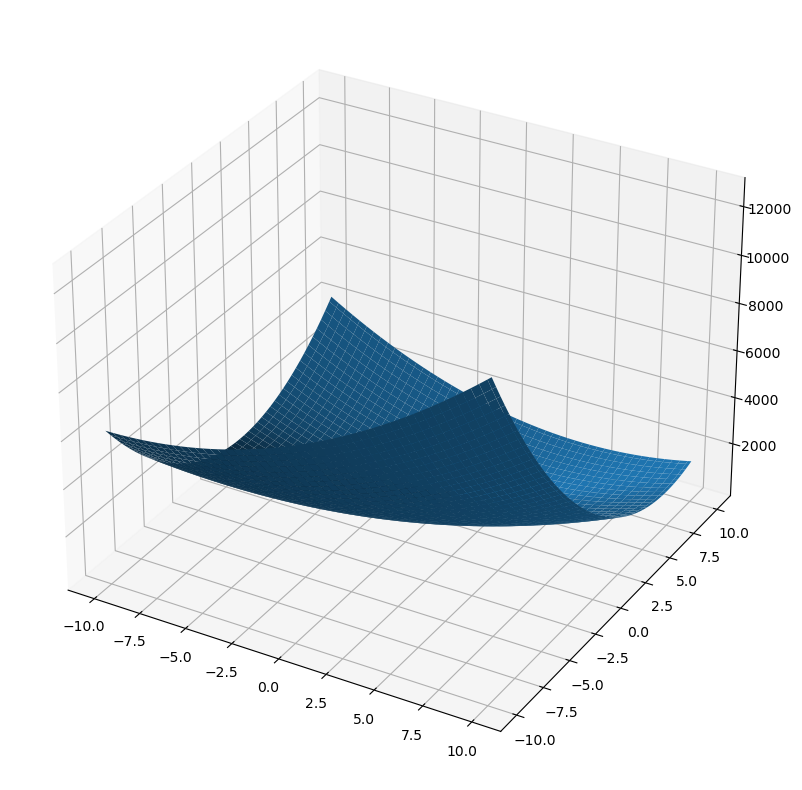

In [53]:
plt.rcParams["figure.figsize"] = (10, 10)
t = np.linspace(-10, 10, 100)
X_t, Y_t = np.meshgrid(t, t)
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(X_t, Y_t, get_error([X_t, Y_t]))

In [91]:
def run(grad_desc, lr_scheduler, x, y):
    points = grad_desc(x, y, lr_scheduler, batch_size=5)
    points = points.reshape(points.size // 2, 2)
    plt.plot(points[:, 0], points[:, 1], 'o-')
    pnt = [get_error([p[0], p[1]]) for p in points]
    pnt = list(set(pnt))
    plt.contour(X_t, Y_t, get_error([X_t, Y_t]), levels=sorted(pnt))
    #print(points)
    print(points.size // 2)

346


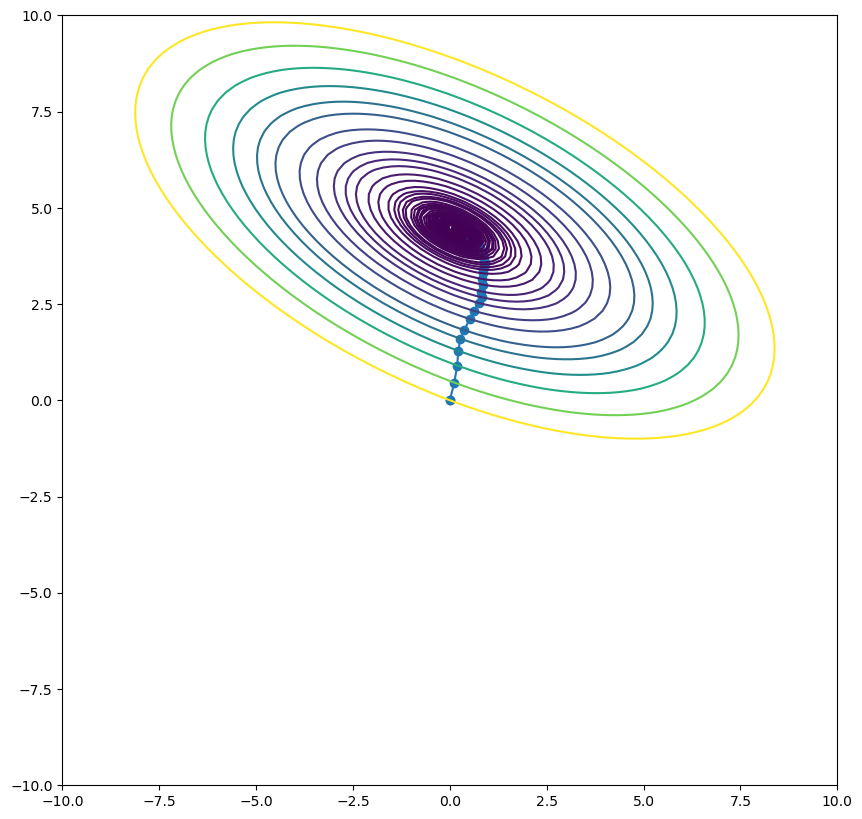

In [134]:
run(StochasticGradDesc().get_min, const_lr, X, Y)

310


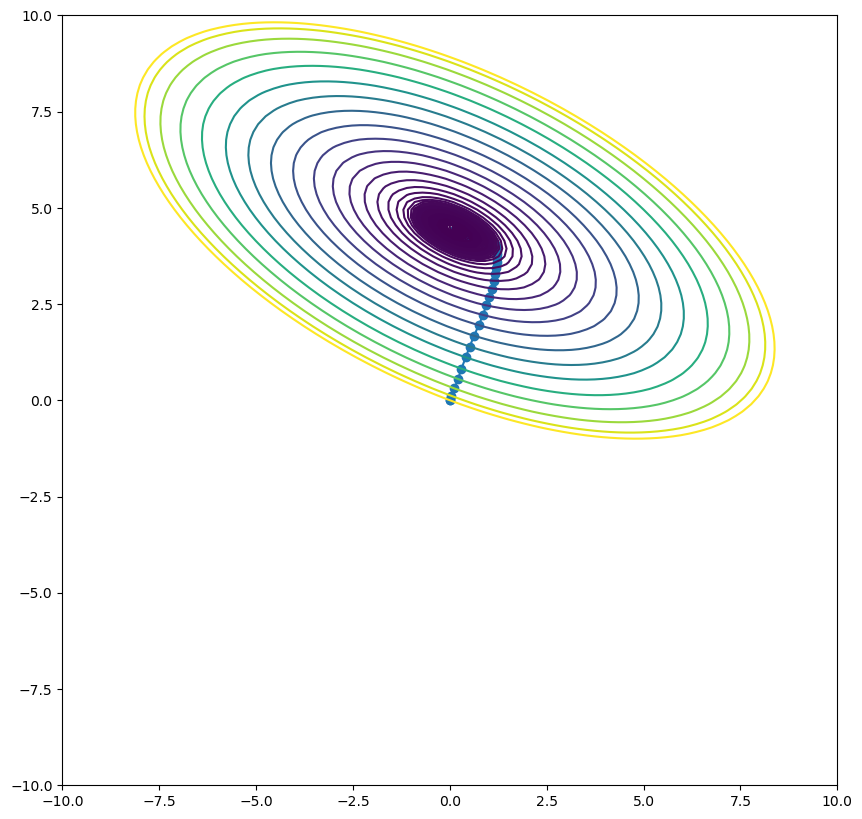

In [135]:
run(NesterovStochasticDesc().get_min, const_lr, X, Y)

310


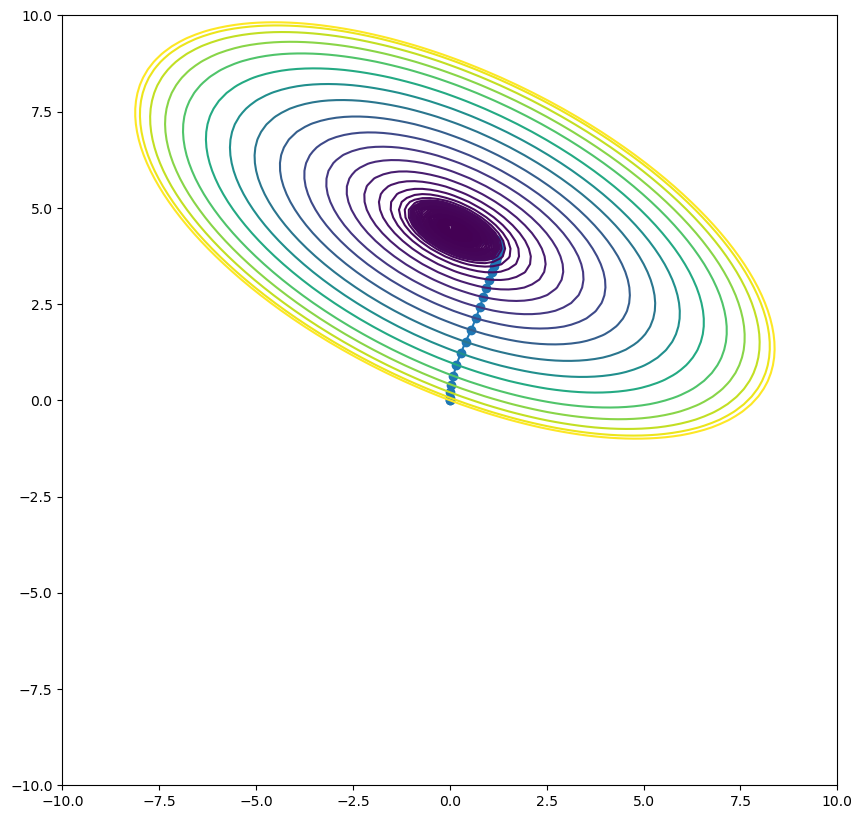

In [136]:
run(MomentumStochasticDesc().get_min, const_lr, X, Y)

16


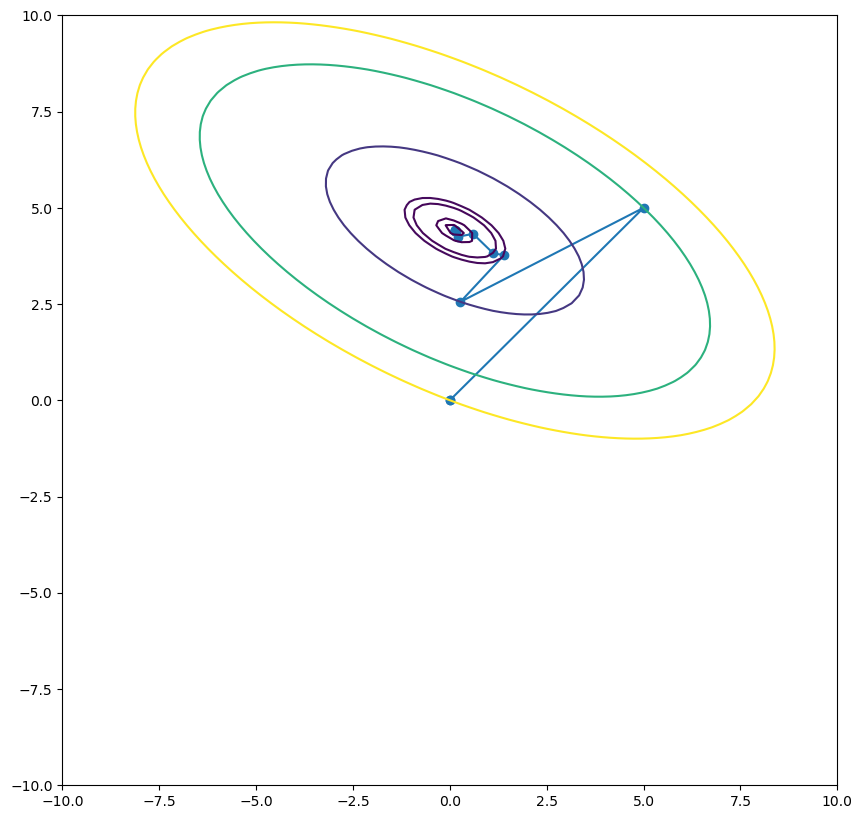

In [137]:
run(AdaGradStochasticDesc().get_min, const_lr, X, Y)

184


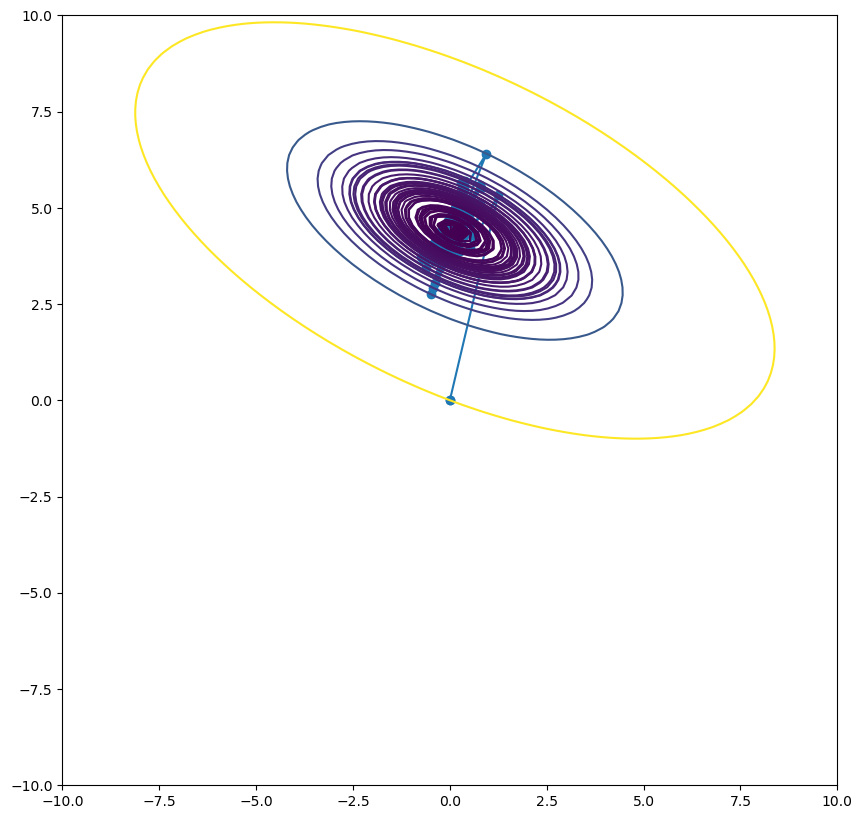

In [138]:
run(RMSStochasticDesc().get_min, exponential_lr, X, Y)

In [139]:
test(AdamStochasticDesc().get_min, exponential_lr, X, Y)


[0.12864936 4.41080981]
iterations: 602, batch_size: 1, computing_time: 0.106975s, arithmetic operations: 24004, peak was 0.172434MB
[0.13011192 4.40995002]
iterations: 245, batch_size: 2, computing_time: 0.035539s, arithmetic operations: 11672, peak was 0.010252MB
[0.1299625  4.40995672]
iterations: 279, batch_size: 3, computing_time: 0.036552s, arithmetic operations: 16078, peak was 0.011336MB
[0.12981199 4.4101765 ]
iterations: 207, batch_size: 4, computing_time: 0.023291s, arithmetic operations: 14366, peak was 0.009004MB
[0.13017643 4.40990906]
iterations: 210, batch_size: 5, computing_time: 0.022274s, arithmetic operations: 17492, peak was 0.0091MB
[0.13025127 4.40981077]
iterations: 208, batch_size: 6, computing_time: 0.024462s, arithmetic operations: 20624, peak was 0.157107MB
[0.13004247 4.40996326]
iterations: 204, batch_size: 7, computing_time: 0.023432s, arithmetic operations: 23864, peak was 0.157123MB
[0.12981226 4.41013597]
iterations: 252, batch_size: 8, computing_time

206


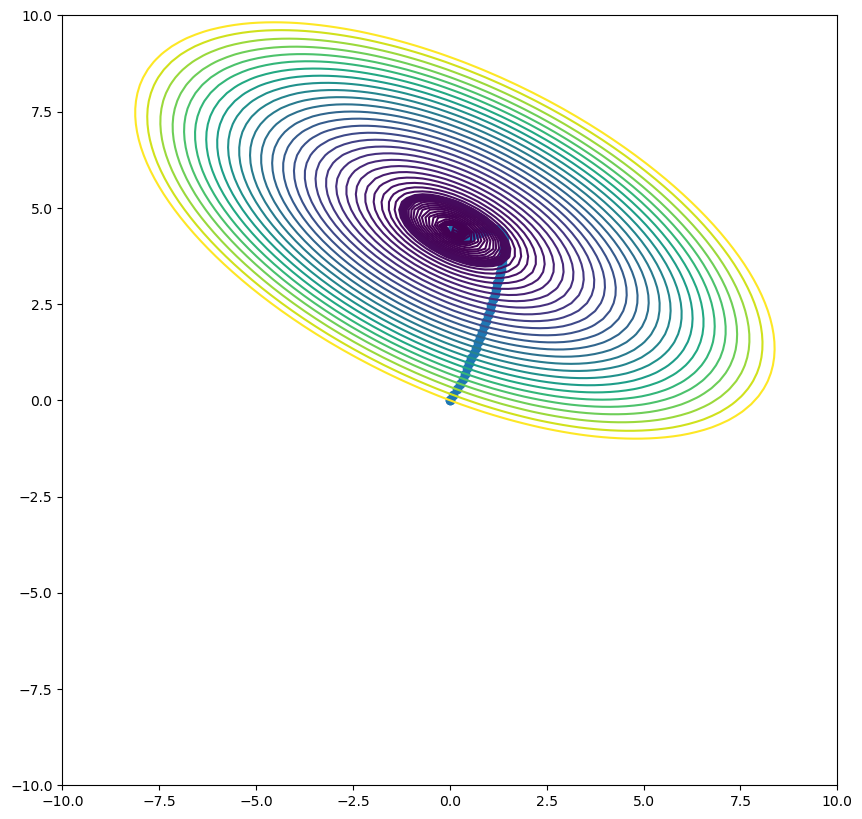

In [140]:
run(AdamStochasticDesc().get_min, const_lr, X, Y)